In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - loss: 0.0120
Average validation loss: 0.6528664827346802
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - loss: 0.0120 - val_loss: 0.6529
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - loss: 0.0078 - val_loss: 0.6529
Average validation loss: 0.6704347729682922
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step - loss: 0.0078 - val_loss: 0.6617
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 518ms/step - loss: 0.0057 - val_loss: 0.6617
Average validation loss: 0.5341593027114868
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 529ms/step - loss: 0.0057 - val_loss: 0.6192
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_5.pth'.
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step - loss: 0.0044 - val_loss: 0.6192
Average validation loss: 0.385

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - loss: 7.5316e-07
Average validation loss: 0.06008874252438545
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - loss: 7.5316e-07 - val_loss: 0.0601
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step - loss: 7.4356e-07 - val_loss: 0.0601
Average validation loss: 0.05458724685013294
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 524ms/step - loss: 7.4356e-07 - val_loss: 0.0573
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 522ms/step - loss: 7.2960e-07 - val_loss: 0.0573
Average validation loss: 0.1399034522473812
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - loss: 7.2960e-07 - val_loss: 0.0849
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 519ms/step - loss: 7.1507e-07 - val_loss: 0.0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - loss: 3.7772e-07
Average validation loss: 0.04721480421721935
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step - loss: 3.7772e-07 - val_loss: 0.0472
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - loss: 3.6555e-07 - val_loss: 0.0472
Average validation loss: 0.07218119005362193
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - loss: 3.6555e-07 - val_loss: 0.0597
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 523ms/step - loss: 3.7746e-07 - val_loss: 0.0597
Average validation loss: 0.049073852598667145
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 532ms/step - loss: 3.7746e-07 - val_loss: 0.0562
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 523ms/step - loss: 3.6699e-07 - val_loss: 0.0562
Average validation loss: 0.051996923983097076
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 532ms/step - loss: 3.6699e-07 - val_loss: 0.0551
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 523ms/step - loss: 2.0344e-07
Average validation loss: 0.04356619017198682
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - loss: 2.0344e-07 - val_loss: 0.0436
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 527ms/step - loss: 1.9987e-07 - val_loss: 0.0436
Average validation loss: 0.05712216114625335
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - loss: 1.9987e-07 - val_loss: 0.0503
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 524ms/step - loss: 1.9826e-07 - val_loss: 0.0503
Average validation loss: 0.04027296369895339
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 531ms/step - loss: 1.9826e-07 - val_loss: 0.0470
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 522ms/step - loss: 1.9283e-0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 520ms/step - loss: 1.8152e-07
Average validation loss: 0.025680903811007738
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 528ms/step - loss: 1.8152e-07 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - loss: 1.7289e-07 - val_loss: 0.0257
Average validation loss: 0.02685529738664627
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 531ms/step - loss: 1.7289e-07 - val_loss: 0.0263
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 525ms/step - loss: 1.5709e-07 - val_loss: 0.0263
Average validation loss: 0.027713465690612792
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 533ms/step - loss: 1.5709e-07 - val_loss: 0.0267
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - loss: 1.4868e-07 - val_loss: 0.0267
Average validation loss: 0.018312646076083183
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 528ms/step - loss: 1.4868e-07 - val_loss: 0.0246
Saved 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step - loss: 2.5350e-07
Average validation loss: 0.028692819488545258
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - loss: 2.5350e-07 - val_loss: 0.0287
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 520ms/step - loss: 2.3704e-07 - val_loss: 0.0287
Average validation loss: 0.02320006148268779
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 528ms/step - loss: 2.3704e-07 - val_loss: 0.0259
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 521ms/step - loss: 2.2263e-07 - val_loss: 0.0259
Average validation loss: 0.0252683626798292
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 529ms/step - loss: 2.2263e-07 - val_loss: 0.0257
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 527ms/step - loss: 2.1386e

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 519ms/step - loss: 3.1545e-07
Average validation loss: 0.04832612876780331
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 527ms/step - loss: 3.1545e-07 - val_loss: 0.0483
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 526ms/step - loss: 2.6484e-07 - val_loss: 0.0483
Average validation loss: 0.06523019163869322
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 534ms/step - loss: 2.6484e-07 - val_loss: 0.0568
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 521ms/step - loss: 2.3926e-07 - val_loss: 0.0568
Average validation loss: 0.046221422217786315
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 529ms/step - loss: 2.3926e-07 - val_loss: 0.0533
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 524ms/step - loss: 2.2163

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 520ms/step - loss: 1.5507e-07
Average validation loss: 0.02036456950008869
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 528ms/step - loss: 1.5507e-07 - val_loss: 0.0204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - loss: 1.3082e-07 - val_loss: 0.0204
Average validation loss: 0.02458764399246623
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 528ms/step - loss: 1.3082e-07 - val_loss: 0.0225
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 523ms/step - loss: 1.1398e-07 - val_loss: 0.0225
Average validation loss: 0.01982360620362063
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 530ms/step - loss: 1.1398e-07 - val_loss: 0.0216
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 101s 523ms/step - loss: 1.0461

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - loss: 1.1414e-07
Average validation loss: 0.01829075058256941
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 532ms/step - loss: 1.1414e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 523ms/step - loss: 9.8420e-08 - val_loss: 0.0183
Average validation loss: 0.02036119352227875
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 531ms/step - loss: 9.8420e-08 - val_loss: 0.0193
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 523ms/step - loss: 8.2383e-08 - val_loss: 0.0193
Average validation loss: 0.01775437606764691
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 531ms/step - loss: 8.2383e-08 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 118s 522ms/step - loss: 7.3876

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 524ms/step - loss: 7.6403e-08
Average validation loss: 0.023300417698919773
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 531ms/step - loss: 7.6403e-08 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 521ms/step - loss: 5.8192e-08 - val_loss: 0.0233
Average validation loss: 0.02428206999320537
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 528ms/step - loss: 5.8192e-08 - val_loss: 0.0238
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 523ms/step - loss: 5.4826e-08 - val_loss: 0.0238
Average validation loss: 0.022255376912653446
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 530ms/step - loss: 5.4826e-08 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 135s 522ms/step - loss: 5.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 525ms/step - loss: 3.1039e-07
Average validation loss: 0.035295126545760364
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 533ms/step - loss: 3.1039e-07 - val_loss: 0.0353
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 525ms/step - loss: 2.3291e-07 - val_loss: 0.0353
Average validation loss: 0.037002528396745525
72/72 ━━━━━━━━━━━━━━━━━━━━ 77s 533ms/step - loss: 2.3291e-07 - val_loss: 0.0361
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 524ms/step - loss: 1.8466e-07 - val_loss: 0.0361
Average validation loss: 0.03434987381721536
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 532ms/step - loss: 1.8466e-07 - val_loss: 0.0355
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 153s 523ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 522ms/step - loss: 5.9412e-08
Average validation loss: 0.03769747414626181
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 530ms/step - loss: 5.9412e-08 - val_loss: 0.0377
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 522ms/step - loss: 6.0339e-08 - val_loss: 0.0377
Average validation loss: 0.022475458029657603
80/80 ━━━━━━━━━━━━━━━━━━━━ 85s 530ms/step - loss: 6.0339e-08 - val_loss: 0.0301
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 522ms/step - loss: 5.1728e-08 - val_loss: 0.0301
Average validation loss: 0.028758231387473642
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 530ms/step - loss: 5.1728e-08 - val_loss: 0.0296
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 169s 521ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 526ms/step - loss: 1.8811e-07
Average validation loss: 0.024773346124372136
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 533ms/step - loss: 1.8811e-07 - val_loss: 0.0248
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 524ms/step - loss: 1.6706e-07 - val_loss: 0.0248
Average validation loss: 0.02519270669048031
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 531ms/step - loss: 1.6706e-07 - val_loss: 0.0250
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 523ms/step - loss: 1.4945e-07 - val_loss: 0.0250
Average validation loss: 0.030393433369075257
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 531ms/step - loss: 1.4945e-07 - val_loss: 0.0268
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 203s 524ms/step - loss: 1.3986e-07 - val_loss: 0.0268
Average validation loss: 0.03366615045039604
96/96 ━━━━━━━━━━━━━━━━━━━━ 204s 531ms/step - loss: 1.3986e-07 - val_loss: 0.0285


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 63s 524ms/step - loss: 1.4124e-07
Average validation loss: 0.01731451133673545
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 532ms/step - loss: 1.4124e-07 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 127s 524ms/step - loss: 1.1510e-07 - val_loss: 0.0173
Average validation loss: 0.02283027363785853
120/120 ━━━━━━━━━━━━━━━━━━━━ 128s 531ms/step - loss: 1.1510e-07 - val_loss: 0.0201
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 524ms/step - loss: 9.6825e-08 - val_loss: 0.0201
Average validation loss: 0.016978674405254423
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 532ms/step - loss: 9.6825e-08 - val_loss: 0.0190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 254s 524m

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 75s 524ms/step - loss: 1.9983e-07
Average validation loss: 0.01741066071473243
144/144 ━━━━━━━━━━━━━━━━━━━━ 77s 531ms/step - loss: 1.9983e-07 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 152s 522ms/step - loss: 1.6459e-07 - val_loss: 0.0174
Average validation loss: 0.02158512975357654
144/144 ━━━━━━━━━━━━━━━━━━━━ 153s 530ms/step - loss: 1.6459e-07 - val_loss: 0.0195
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 228s 523ms/step - loss: 1.4110e-07 - val_loss: 0.0195
Average validation loss: 0.023828758460594044
144/144 ━━━━━━━━━━━━━━━━━━━━ 229s 530ms/step - loss: 1.4110e-07 - val_loss: 0.0209
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 305s 524ms/step - loss: 1.2352e-07 - val_loss: 0.0209
Average validation loss: 0.02300392592789851
144/144 ━━━━━━━━━━━━━━━━━━━━ 306s 532ms/step - loss: 1.2352e-07 - va

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 84s 525ms/step - loss: 7.1902e-08
Average validation loss: 0.02112474640198343
160/160 ━━━━━━━━━━━━━━━━━━━━ 85s 532ms/step - loss: 7.1902e-08 - val_loss: 0.0211
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 169s 525ms/step - loss: 5.6851e-08 - val_loss: 0.0211
Average validation loss: 0.019414796255296095
160/160 ━━━━━━━━━━━━━━━━━━━━ 170s 532ms/step - loss: 5.6851e-08 - val_loss: 0.0203
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 254s 524ms/step - loss: 4.8380e-08 - val_loss: 0.0203
Average validation loss: 0.020372716526617297
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 532ms/step - loss: 4.8380e-08 - val_loss: 0.0203
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 339s 522

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 105s 524ms/step - loss: 8.1775e-08
Average validation loss: 0.02278941155600478
200/200 ━━━━━━━━━━━━━━━━━━━━ 106s 532ms/step - loss: 8.1775e-08 - val_loss: 0.0228
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 211s 523ms/step - loss: 7.0415e-08 - val_loss: 0.0228
Average validation loss: 0.02691688325969153
200/200 ━━━━━━━━━━━━━━━━━━━━ 213s 531ms/step - loss: 7.0415e-08 - val_loss: 0.0249
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 524ms/step - loss: 6.1404e-08 - val_loss: 0.0249
Average validation loss: 0.023599873456405476
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 532ms/step - loss: 6.1404e-08 - val_loss: 0.0244
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 423s 523ms/step - loss: 5.7255e-08 - val_loss: 0.0244
Average validation loss: 0.020355912186496426
200/200 ━━━━━━━━━━━━━━━━━━━━ 425s 530ms/step - loss: 5.7255e-08 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 186s 775ms/step - loss: 9.1996e-08
Average validation loss: 0.02290635430326802
240/240 ━━━━━━━━━━━━━━━━━━━━ 189s 786ms/step - loss: 9.1996e-08 - val_loss: 0.0229
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 375s 776ms/step - loss: 8.2071e-08 - val_loss: 0.0229
Average validation loss: 0.02159529626830287
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 786ms/step - loss: 8.2071e-08 - val_loss: 0.0223
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_70\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 775ms/step - loss: 7.5293e-08 - val_loss: 0.0223
Average validation loss: 0.020491552932223083
240/240 ━━━━━━━━━━━━━━━━━━━━ 566s 785ms/step - loss: 7.5293e-08 - val_loss: 0.0217
Saved model weights to 'c:\天_11157065\git\Rippl

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.15567897509783507, 0.06288790136575699, 0.03896657852455974, 0.03872461851104163, 0.022498001366853718, 0.020647331546060747, 0.03276594661083072, 0.02574729159163932, 0.024440706987266567, 0.02508315193466842, 0.029320197041249933, 0.029214853179175403, 0.0329749339040912, 0.02803132387470881, 0.02877639765549652, 0.025749316617855587, 0.027203206190280618, 0.025688741132918115]
std_val_losses =  [0.14552522384847577, 0.03114273803371552, 0.017397690786701756, 0.011515189902259328, 0.007309179187173596, 0.00561593429313791, 0.010494017723295425, 0.0062839723158474815, 0.004439250038015831, 0.00521277246263739, 0.0091075931703962, 0.0063209771863270425, 0.00812655110209064, 0.005967146928526492, 0.005679717273647414, 0.006400807438435656, 0.0069244435537950165, 0.00627369373872953]


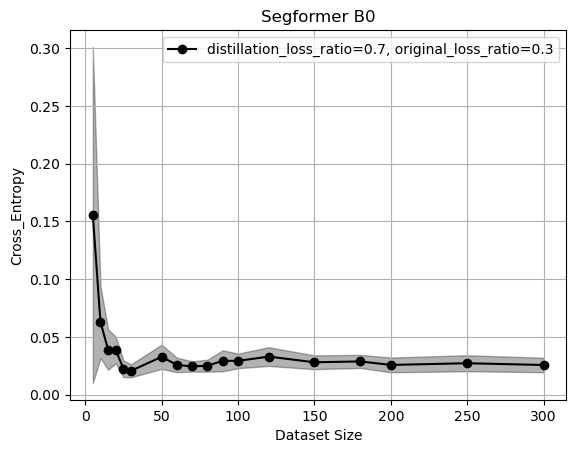

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()